# Stochastic models for the daily PM 2.5 concentration

Created by Anders D. Sleire ([anders.sleire@uib.no](mailto:anders.sleire@uib.no))

In [532]:
library(data.table)
library(ggplot2)
library(latex2exp)
library(MASS)
library(sn)
library(fGarch)
#library(sde)
#library(yuima)
library(forecast)
options(repr.plot.width = 6, repr.plot.height = 3)

ERROR: Error in library(forecast): there is no package called ‘forecast’


In [531]:
install.packages('forecast')

Installing package into ‘/home/anders/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Warning message in download.file(url, destfile, method, mode = "wb", ...):
“cannot open URL 'https://cloud.r-project.org/src/contrib/forecast_8.10.tar.gz': HTTP status was '404 Not Found'”Warning message in download.packages(pkgs, destdir = tmpd, available = available, :
“download of package ‘forecast’ failed”

In [501]:
# import hourly aqi (avg) and pm2.5 concentration (conc) data
dat = fread("../data/aqi.csv")
head(dat)

day        hour avg conc city
1 2010-01-02 0    189 129  0   
2 2010-01-02 1    199 148  0   
3 2010-01-02 2    209 159  0   
4 2010-01-02 3    231 181  0   
5 2010-01-02 4    194 138  0   
6 2010-01-02 5    179 109  0

In [502]:
# calculate daily averages, format dates, log pollution concentration, add time t and day-of-year number
dat <- dat[, .(aqi=round(mean(avg)), p=round(mean(conc, na.rm = T))), by = day]
dat$day <- as.Date(dat$day)
dat$log_p <- log(dat$p)
dat$t <- seq_along(dat$day)
dat$yday <- yday(dat$day)
head(dat)

day        aqi p   log_p    t yday
1 2010-01-02 201 146 4.983607 1 2   
2 2010-01-03 163  79 4.369448 2 3   
3 2010-01-04  90  31 3.433987 3 4   
4 2010-01-05 111  42 3.737670 4 5   
5 2010-01-06 128  56 4.025352 5 6   
6 2010-01-07 139  69 4.234107 6 7

[1] 0.1010101 0.1414141

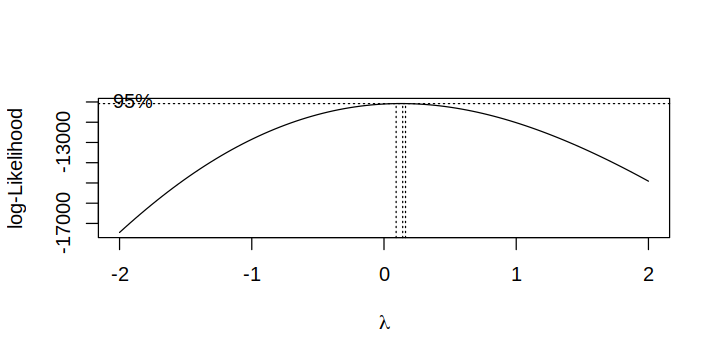

In [503]:
# find lambda for box cox transform
out <- boxcox(lm(dat$p~1))
range(out$x[out$y > max(out$y)-qchisq(0.95,1)/2])

In [504]:
# keep original p in variable pp
dat$pp <- dat$p

In [505]:
# replace p with the box cox transform
dat$p <- (dat$p**0.14 - 1)/0.14

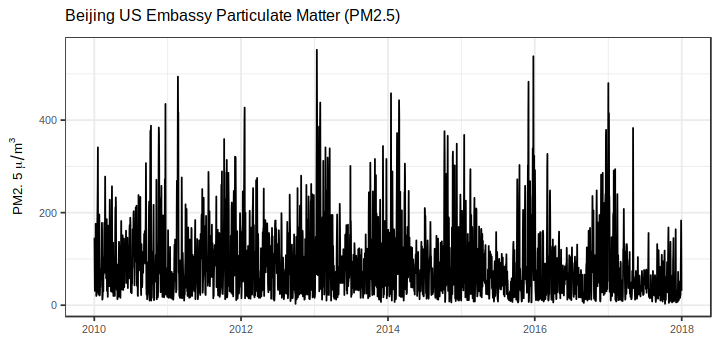

In [506]:
# plot daily PM2.5 concentration averages
ggplot(dat, aes(x = day)) + 
  geom_line(aes(y = pp)) + theme_bw() +
  xlab("") + ylab(TeX("PM2.5 $\\mu/m^3$")) +
  theme(legend.position="none") + ggtitle("Beijing US Embassy Particulate Matter (PM2.5)") +
  theme(text = element_text(size=8))

### Model building blocks

$P(t)$ - the PM 2.5 pollutant concentration

$\Lambda(t)$ - a seasonal function

$X(t)$ - a stochastic component

### Alternative model specifications

1. $P(t) = e^{\Lambda(t) + X(t)}$

2. $P(t) = \Lambda(t) e^{X(t)}$

3. $P(t) = e^{\Lambda(t)} X(t)$

### Alternative seasonal functions

A. $\Lambda (t) = a_0 + a_1 t + a_2 \cos\big(\frac{2\pi}{365}t\big) + a_3 \sin\big(\frac{2\pi}{365}t\big)$ - trend and annual periodicity

B. $\Lambda (t) = a_0 + a_1 t + a_2 \cos\big(\frac{2\pi}{365}t\big) + a_3 \sin\big(\frac{2\pi}{365}t\big)+ a_4 \cos\big(\frac{4\pi}{365}t\big) + a_5 \sin\big(\frac{4\pi}{365}t\big)$ - trend and annual and biannual periodicity

### Alternative specifications for the stochastic component

I. $dX(t)  = \theta \big(\mu - X(t)\big)dt + \sigma(t) dW(t)$

II. $dX(t) = \theta \big(\mu - X(t)\big)dt + \sigma(t) dL(t)$

III. $dX(t) = \theta \big(\mu - X(t)\big)dt + \sigma(t) dL(t)$

## Stepwise modelling approach:
1. Estimate a seasonal function for $ln\big(P(t)\big)$
2. Deseasonalize $X(t) = ln\big(P(t)\big) - \Lambda (t)$
3. Evaluate aternative models for deseasonalized series $X(t)$

# Selected model: Use model specification 1. and seasonal function A. above

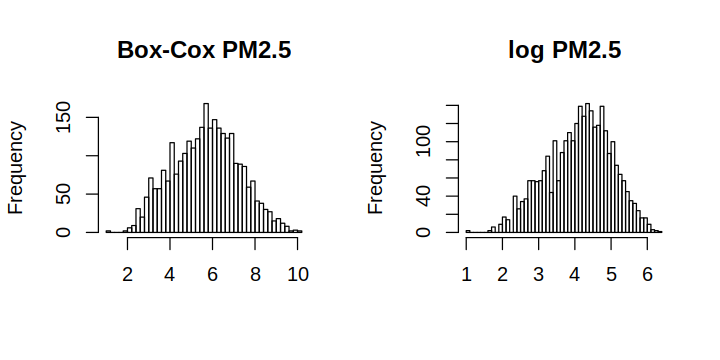

In [507]:
par(mfrow=c(1,2))
hist(dat$p, breaks = 50, main='Box-Cox PM2.5', xlab="")
hist(dat$log_p, breaks = 50, main='log PM2.5', xlab="")

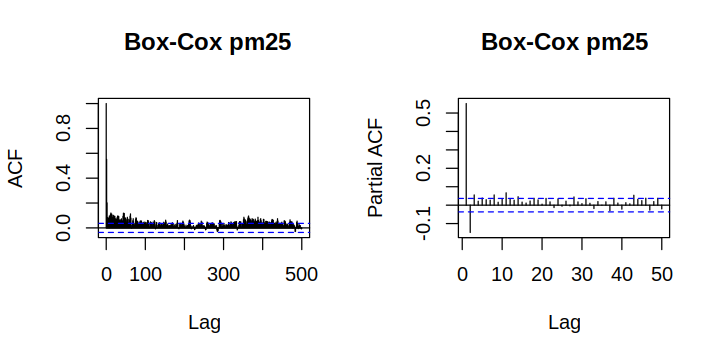

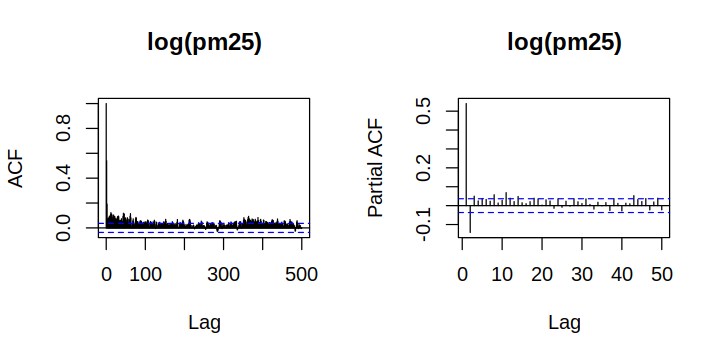

In [508]:
par(mfrow=c(1,2))
acf(dat$p, lag.max = 500,main=" Box-Cox pm25")
pacf(dat$p, lag.max = 50, main="Box-Cox pm25")
acf(dat$log_p, lag.max = 500,main="log(pm25)")
pacf(dat$log_p, lag.max = 50, main="log(pm25)")

### 1. Step: Fit seasonal functions A. and B. on $P(t)$ and $ln\big(P(t)\big)$

In [509]:
# fit seasonal function for log concentration
log_s <- lm(log_p ~ t + cos( 2*pi*t / 365 ) + sin( 2*pi*t / 365 ), data = dat)
box_s <- lm(p ~ t + cos( 2*pi*t / 365 ) + sin( 2*pi*t / 365 ), data = dat)

In [510]:
summary(log_s)


Call:
lm(formula = log_p ~ t + cos(2 * pi * t/365) + sin(2 * pi * t/365), 
    data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.14393 -0.57246  0.09362  0.61960  2.20807 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          4.470e+00  3.193e-02 140.021  < 2e-16 ***
t                   -2.326e-04  1.921e-05 -12.110  < 2e-16 ***
cos(2 * pi * t/365)  9.251e-02  2.262e-02   4.090 4.43e-05 ***
sin(2 * pi * t/365) -6.013e-02  2.247e-02  -2.676   0.0075 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8537 on 2877 degrees of freedom
Multiple R-squared:  0.05547,	Adjusted R-squared:  0.05448 
F-statistic: 56.32 on 3 and 2877 DF,  p-value: < 2.2e-16


In [511]:
summary(box_s)


Call:
lm(formula = p ~ t + cos(2 * pi * t/365) + sin(2 * pi * t/365), 
    data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7044 -1.0602  0.0893  1.0626  4.4396 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.284e+00  5.645e-02 111.329  < 2e-16 ***
t                   -4.076e-04  3.396e-05 -12.002  < 2e-16 ***
cos(2 * pi * t/365)  1.937e-01  3.999e-02   4.844 1.34e-06 ***
sin(2 * pi * t/365) -1.355e-01  3.973e-02  -3.411 0.000656 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.509 on 2877 degrees of freedom
Multiple R-squared:  0.0578,	Adjusted R-squared:  0.05682 
F-statistic: 58.83 on 3 and 2877 DF,  p-value: < 2.2e-16


In [512]:
data.frame(log_s = log_s$coefficients, box_s = box_s$coefficients)

log_s         box_s       
(Intercept)          4.4703601735  6.284098001
t                   -0.0002326182 -0.000407605
cos(2 * pi * t/365)  0.0925149877  0.193716692
sin(2 * pi * t/365) -0.0601296347 -0.135533542

In [513]:
# seasonal function predicions
dat$log_s <- predict(log_s, newdata = dat)
dat$box_s <- predict(box_s, newdata = dat)

In [514]:
head(dat)

day        aqi p        log_p    t yday pp  log_s    box_s   
1 2010-01-02 201 7.208116 4.983607 1 2    146 4.561594 6.475045
2 2010-01-03 163 6.025747 4.369448 2 3     79 4.560285 6.472219
3 2010-01-04  90 4.409287 3.433987 3 4     31 4.558950 6.469337
4 2010-01-05 111 4.911023 3.737670 4 5     42 4.557588 6.466400
5 2010-01-06 128 5.406408 4.025352 5 6     56 4.556201 6.463408
6 2010-01-07 139 5.778581 4.234107 6 7     69 4.554787 6.460363

In [515]:
#invBoxCox <- function(x, lambda) if (lambda == 0) exp(x) else (lambda*x + 1)^(1/lambda)

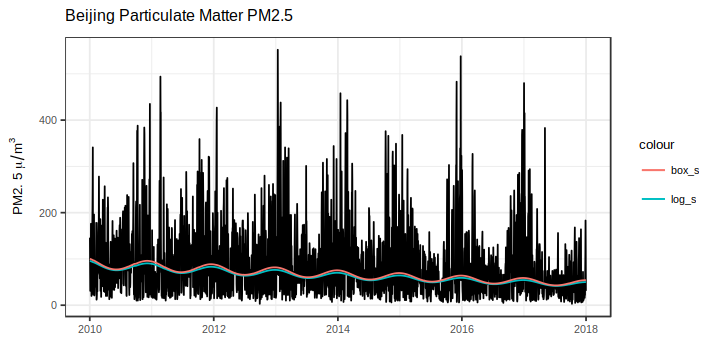

In [516]:
# PM2.5 plot with trend functions
ggplot(dat, aes(x = day)) + 
  geom_line(aes(y = pp)) + theme_bw() +
  geom_line(aes(y = exp(log_s), colour = 'log_s')) + 
  geom_line(aes(y = invBoxCox(dat$box_s, 0.14), colour = 'box_s')) + 
  xlab("") + ylab(TeX("PM2.5 $\\mu/m^3$")) +
  ggtitle("Beijing Particulate Matter PM2.5") +
  theme(text = element_text(size=8))

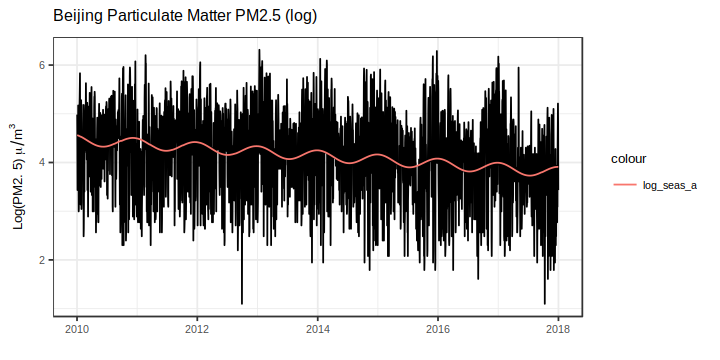

In [517]:
# log PM2.5 plot with trend functions
ggplot(dat, aes(x = day)) + 
  geom_line(aes(y = log_p)) + theme_bw() +
  geom_line(aes(y = log_s, colour = 'log_seas_a')) + 
  #geom_line(aes(y = log_seas_b, colour = 'log_seas_b')) + 
  xlab("") + ylab(TeX("Log(PM2.5) $\\mu/m^3$")) +
  ggtitle("Beijing Particulate Matter PM2.5 (log)") +
  theme(text = element_text(size=8)) 

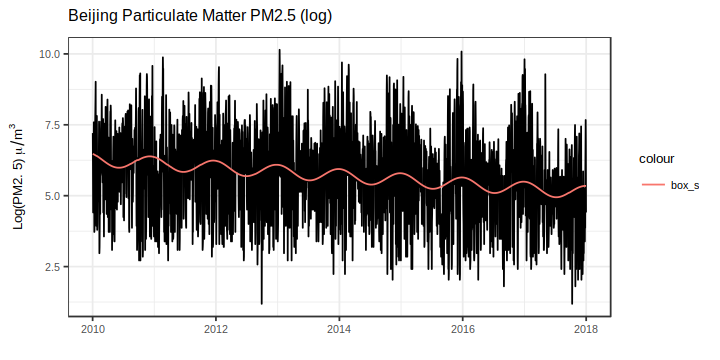

In [518]:
# log PM2.5 plot with trend functions
ggplot(dat, aes(x = day)) + 
  geom_line(aes(y = p)) + theme_bw() +
  geom_line(aes(y = box_s, colour = 'box_s')) + 
  #geom_line(aes(y = log_seas_b, colour = 'log_seas_b')) + 
  xlab("") + ylab(TeX("Log(PM2.5) $\\mu/m^3$")) +
  ggtitle("Beijing Particulate Matter PM2.5 (log)") +
  theme(text = element_text(size=8)) 

### 2. Step: Deseasonalize $P(t)$ and $ln\big(P(t)\big)$

In [519]:
# deseasonalized values
# must chaange/ add -- divide by seasonal for some specifications (not relevant for model 1.)
#dat$conc_a <- dat$conc - predict(seas_a, data.frame(dat$t))
#dat$conc_a <- dat$conc - predict(seas_a, data.frame(dat$t))
#dat$conc_b <- dat$conc - predict(seas_b, data.frame(dat$t))

dat$log_conc_a <- dat$log_p - dat$log_s #predict(log_seas_a, data.frame(dat$t))
#dat$log_conc_b <- dat$log_conc - predict(log_seas_b, data.frame(dat$t))b


In [520]:
head(dat)

day        aqi p        log_p    t yday pp  log_s    box_s    log_conc_a
1 2010-01-02 201 7.208116 4.983607 1 2    146 4.561594 6.475045  0.4220128
2 2010-01-03 163 6.025747 4.369448 2 3     79 4.560285 6.472219 -0.1908375
3 2010-01-04  90 4.409287 3.433987 3 4     31 4.558950 6.469337 -1.1249629
4 2010-01-05 111 4.911023 3.737670 4 5     42 4.557588 6.466400 -0.8199188
5 2010-01-06 128 5.406408 4.025352 5 6     56 4.556201 6.463408 -0.5308489
6 2010-01-07 139 5.778581 4.234107 6 7     69 4.554787 6.460363 -0.3206805

In [521]:
# plot deseasonalized log(pm25) concentration
#ggplot(dat, aes(x = day)) + 
#  geom_line(aes(y = conc_a)) + theme_bw() +
#  xlab("") + ylab(TeX("deseasonalized log(PM2.5)")) +
#  ggtitle("Deseasonalized log(PM2.5)") +
#  theme(text = element_text(size=8))

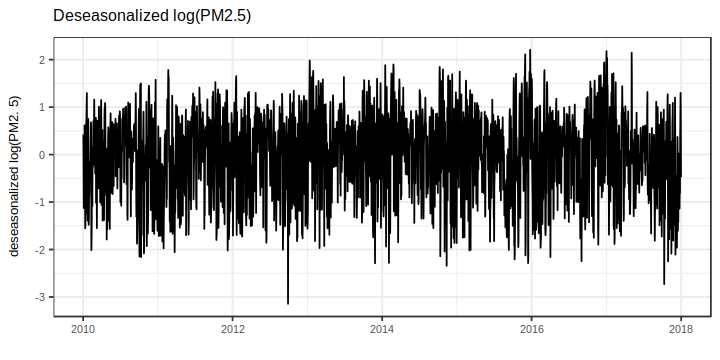

In [522]:
# plot deseasonalized log(pm25) concentration
ggplot(dat, aes(x = day)) + 
  geom_line(aes(y = log_conc_a)) + theme_bw() +
  xlab("") + ylab(TeX("deseasonalized log(PM2.5)")) +
  ggtitle("Deseasonalized log(PM2.5)") +
  theme(text = element_text(size=8))

In [523]:
### Original pm.25 and log(pm.25) series
#par(mfrow=c(1,2))
#acf(dat$conc, lag.max = 500,main="conc pm25")
#pacf(dat$conc, lag.max = 50, main="conc pm25")
#acf(dat$log_conc, lag.max = 500,main="log_conc pm25")
#pacf(dat$log_conc, lag.max = 50, main="log_conc pm25")

### Deseasonalized pm.25 and log(pm.25) series

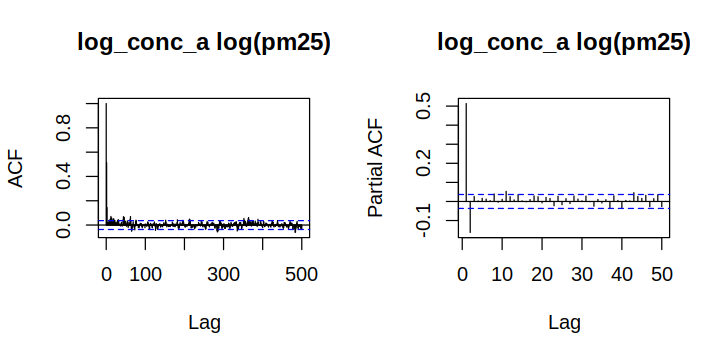

In [524]:
par(mfrow=c(1,2))
acf(dat$log_conc_a, lag.max = 500,main="log_conc_a log(pm25)")
pacf(dat$log_conc_a, lag.max = 50, main="log_conc_a log(pm25)")
#acf(dat$log_conc_b, lag.max = 500,main="log_conc_b log(pm25)")
#pacf(dat$log_conc_b, lag.max = 50, main="log_conc_b log(pm25)")

In [525]:
# evaluate alternative ARIMA
order.matrix <- matrix(0, nrow = 3, ncol = 5 * 2 * 6)
aic.vec <- numeric(5 * 2 * 6)
k <- 1
for (p in 1:5) for (d in 0:1) for (q in 0:5) {
  order.matrix[, k] <- c(p,d,q)
  aic.vec[k] <- AIC(arima(dat$log_conc_a, order=c(p, d, q)))
  k <- k+1
  }
ind <- order(aic.vec, decreasing = FALSE)
aic.vec <- aic.vec[ind]
order.matrix <- order.matrix[, ind]

order.matrix <- t(order.matrix)
result <- cbind(order.matrix, aic.vec)
colnames(result) <- c("p", "d", "q", "AIC")
result

Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”Warning message in arima(dat$log_conc_a, order = c(p, d, q)):
“possible convergence problem: opt

p d q AIC     
 [1,] 3 0 5 6297.604
 [2,] 3 0 1 6298.668
 [3,] 4 0 5 6299.908
 [4,] 5 0 3 6301.606
 [5,] 4 0 2 6302.377
 [6,] 2 0 5 6302.987
 [7,] 4 0 3 6303.542
 [8,] 5 0 4 6303.691
 [9,] 5 0 1 6304.120
[10,] 3 0 4 6304.525
[11,] 2 1 5 6304.812
[12,] 5 0 5 6304.927
[13,] 5 1 3 6307.043
[14,] 3 1 4 6307.100
[15,] 2 1 1 6307.400
[16,] 2 1 2 6308.622
[17,] 3 1 1 6308.688
[18,] 1 1 3 6309.525
[19,] 1 0 1 6310.115
[20,] 2 0 0 6310.121
[21,] 3 0 0 6310.144
[22,] 1 1 2 6310.175
[23,] 2 0 1 6310.200
[24,] 1 0 2 6310.351
[25,] 4 1 1 6310.533
[26,] 3 1 2 6310.787
[27,] 1 1 4 6311.219
[28,] 4 0 0 6312.124
[29,] 1 0 3 6312.191
[30,] 2 0 2 6312.191
[31,] 2 1 3 6312.276
[32,] 3 0 3 6312.348
[33,] 5 1 1 6312.409
[34,] 2 1 4 6312.491
[35,] 4 1 2 6312.508
[36,] 3 1 3 6312.544
[37,] 1 1 5 6312.704
[38,] 5 1 2 6313.219
[39,] 5 0 0 6313.346
[40,] 2 0 3 6314.131
[41,] 4 0 1 6314.141
[42,] 1 0 4 6314.173
[43,] 3 0 2 6314.199
[44,] 4 1 5 6314.301
[45,] 4 1 3 6314.543
[46,] 3 1 5 6314.862
[47,] 4 1 4 6315.013
[48,] 1 0 5 6315.477
[49,] 5 1 4 6315.558
[50,] 2 0 4 6315.855
[51,] 5 1 5 6316.396
[52,] 5 0 2 6317.460
[53,] 4 0 4 6317.789
[54,] 1 0 0 6385.423
[55,] 1 1 1 6388.463
[56,] 5 1 0 6665.698
[57,] 4 1 0 6725.496
[58,] 3 1 0 6813.087
[59,] 2 1 0 6923.194
[60,] 1 1 0 7142.722

### Estimate AR(2) model for the deseasonalized series

In [22]:
arim <- arima(dat$log_conc_a, order=c(2,0,0), include.mean = FALSE)
arim


Call:
arima(x = dat$log_conc_a, order = c(2, 0, 0), include.mean = FALSE)

Coefficients:
         ar1      ar2
      0.5969  -0.1627
s.e.  0.0184   0.0184

sigma^2 estimated as 0.5218:  log likelihood = -3151.06,  aic = 6308.12

In [23]:
(1-pnorm(abs(arim$coef)/sqrt(diag(arim$var.coef))))*2

ar1 ar2 
  0   0

In [24]:
# add ar(2) residuals and squared residuals to dat
dat$res_log_conc_a <- arim$residuals
dat$res_sq_log_conc_a <- arim$residuals**2

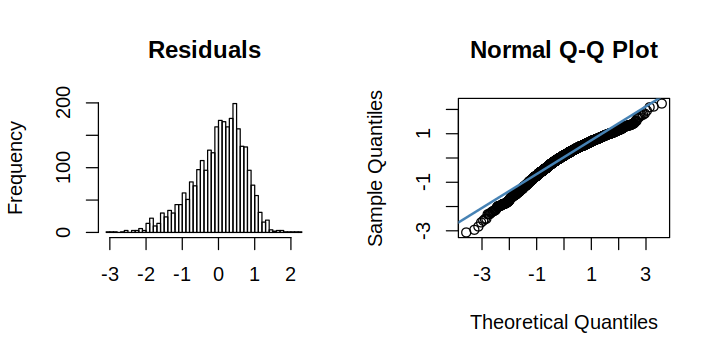

In [25]:
par(mfrow=c(1,2))
hist(dat$res_log_conc_a, breaks = 50, main='Residuals', xlab="")
qqnorm(dat$res_log_conc_a)
qqline(dat$res_log_conc_a, col = "steelblue", lwd = 2)

#### Seasonal volatility in residuals

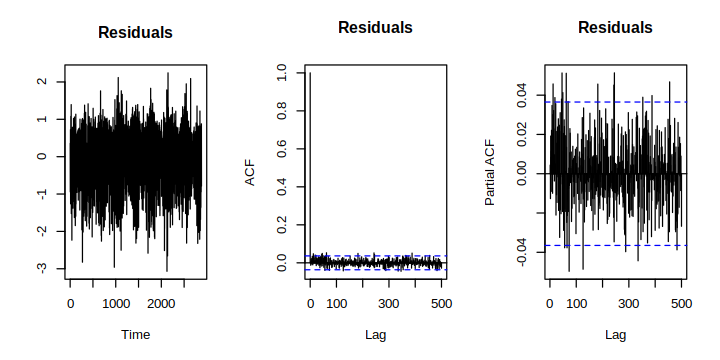

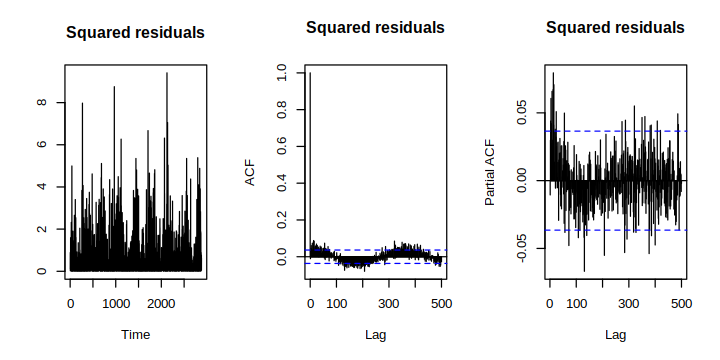

In [26]:
# ar(2) residuals and squared residuals
par(mfrow=c(1,3))
plot(dat$res_log_conc_a, main='Residuals', ylab='')
acf(dat$res_log_conc_a, lag.max = 500, main='Residuals')
pacf(dat$res_log_conc_a, lag.max = 500, main='Residuals')

plot(dat$res_sq_log_conc_a, main='Squared residuals', ylab='')
acf(dat$res_sq_log_conc_a, lag.max = 500, main='Squared residuals')
pacf(dat$res_sq_log_conc_a, lag.max = 500, main='Squared residuals')

In [27]:
#par(mfrow=c(1,3))
#hist(dat$conc, breaks = 50)
#hist(dat$log_conc, breaks = 50)
#hist(dat$log_conc_a, breaks = 50)

### Estimate seasonal function for volatility in residuals (no trend component)

In [28]:
head(dat)

day        avg conc month week yday log_conc t seas_a   log_seas_a conc_a   
1 2010-01-02 201 146  1     1    2    4.983607 1 128.6730 4.561594    17.32702
2 2010-01-03 163  79  1     1    3    4.369448 2 128.4283 4.560285   -49.42830
3 2010-01-04  90  31  1     1    4    3.433987 3 128.1788 4.558950   -97.17876
4 2010-01-05 111  42  1     1    5    3.737670 4 127.9244 4.557588   -85.92443
5 2010-01-06 128  56  1     1    6    4.025352 5 127.6654 4.556201   -71.66537
6 2010-01-07 139  69  1     2    7    4.234107 6 127.4017 4.554787   -58.40166
  log_conc_a res_log_conc_a res_sq_log_conc_a
1  0.4220128  0.3573314     0.12768573       
2 -0.1908375 -0.4020503     0.16164442       
3 -1.1249629 -0.9423696     0.88806042       
4 -0.8199188 -0.1794760     0.03221163       
5 -0.5308489 -0.2245144     0.05040671       
6 -0.3206805 -0.1372499     0.01883754

In [29]:
# vector for storing variance of residuals from ar(2) --> disregard week 53 and day 366
#sig_m <- vector()
#sig_w <- vector()
sig_d <- vector()

# calculation month
#for (i in 1:12){
#    sig_m[i] <- mean(subset(dat, month==i)$res_sq_log_conc_a)
#    #sig_m[i] <- var(subset(dat, month==i)$res_log_conc_a)
#}

# calculation week
#for (i in 1:52){
#    sig_w[i] <- mean(subset(dat, week==i)$res_sq_log_conc_a)
#    #sig_w[i] <- var(subset(dat, week==i)$res_log_conc_a)
#}

# calculation yday (day-of-year)
for (i in 1:365){
    sig_d[i] <- mean(subset(dat, yday==i)$res_sq_log_conc_a)
    #sig_d[i] <- var(subset(dat, yday==i)$res_log_conc_a)
}

# report as data frames
#sig_m_dat <- data.frame(month = 1:12, sigma =sig_m)
#sig_w_dat <- data.frame(week = 1:52, sigma =sig_w)
sig_d_dat <- data.frame(yday = 1:365, sigma =sig_d)

In [30]:
# monthly
#ggplot(sig_m_dat, aes(x = month, y = sigma)) + geom_line() + scale_x_continuous(breaks=1:12) +
#theme(text = element_text(size=8)) + theme_bw()

In [31]:
# weekly
#ggplot(sig_w_dat, aes(x = week, y = sigma)) + geom_line() + 
#theme(text = element_text(size=8)) + theme_bw()

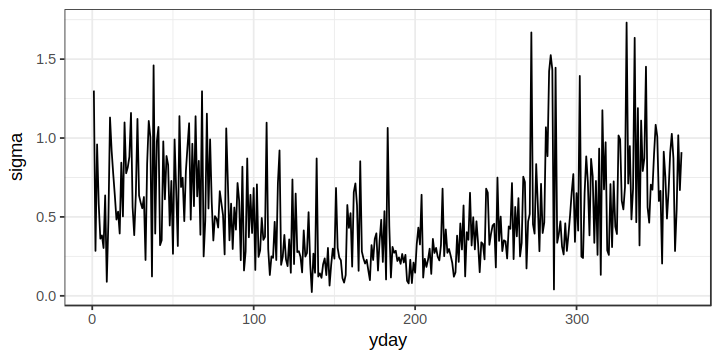

In [32]:
# day-of-year
ggplot(sig_d_dat, aes(x = yday, y = sigma)) + geom_line() + 
theme(text = element_text(size=8)) + theme_bw()

In [33]:
#ggplot(head(dat, 365), aes(x = t, y = res_sq_log_conc_a)) + geom_line() + 
#theme(text = element_text(size=8)) + theme_bw()

In [34]:
# fit seasonal functions on concentration and log concentration
vol_res_a <- lm(sig_d_dat$sigma ~ cos( 2*pi*sig_d_dat$yday / 365 ) + sin( 2*pi*sig_d_dat$yday / 365 ))
#vol_res_b <- lm(sig_d_dat$sigma ~ cos( 2*pi*sig_d_dat$yday / 365 ) + sin( 2*pi*sig_d_dat$yday / 365 ) 
#                + cos( 4*pi*sig_d_dat$yday / 365 ) + sin( 4*pi*sig_d_dat$yday/ 365 ))

In [35]:
vol_res_a <- lm(sigma ~ cos( 2*pi*yday / 365 ) + sin( 2*pi*yday / 365 ), data = sig_d_dat)
#vol_res_b <- lm(sigma ~ cos( 2*pi*yday / 365 ) + sin( 2*pi*yday / 365 ) + cos( 4*pi*yday / 365 ) + sin( 4*pi*yday/ 365 ), data = sig_d_dat)

In [36]:
#summary(vol_res_a)
#summary(vol_res_b)

In [37]:
data.frame(seavol_res_as_a = vol_res_a$coefficients)

seavol_res_as_a
(Intercept)             0.52168566    
cos(2 * pi * yday/365)  0.24556902    
sin(2 * pi * yday/365) -0.01170633

In [38]:
#data.frame(seavol_res_as_b = vol_res_b$coefficients)

In [39]:
sig_d_dat$sigma_a <- predict(vol_res_a, newdata = sig_d_dat)
#sig_d_dat$sigma_b <- predict(vol_res_b, newdata = sig_d_dat)

In [40]:
head(sig_d_dat)

yday sigma     sigma_a  
1 1    1.3007507 0.7670168
2 2    0.2849611 0.7667062
3 3    0.9593318 0.7663230
4 4    0.5836297 0.7658673
5 5    0.3622556 0.7653393
6 6    0.3827220 0.7647391

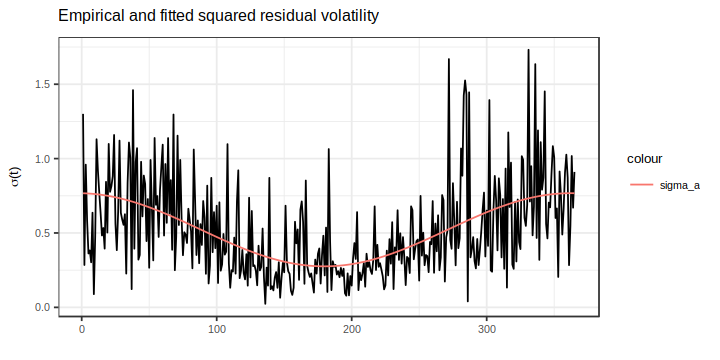

In [41]:
ggplot(sig_d_dat, aes(x = yday)) + 
  geom_line(aes(y = sigma)) + theme_bw() +
  geom_line(aes(y = sigma_a, colour = 'sigma_a')) + 
  #geom_line(aes(y = sigma_b, colour = 'sigma_b')) + 
  xlab("") + ylab(TeX("$\\sigma(t)$")) +
  ggtitle("Empirical and fitted squared residual volatility") +
  theme(text = element_text(size=8)) 

In [42]:
# predictions for squared residuals
dat$sigma_a <- predict(vol_res_a, newdata = dat)
#dat$sigma_b <- predict(vol_res_b, newdata = dat)

In [43]:
head(dat)

day        avg conc month week yday log_conc t seas_a   log_seas_a conc_a   
1 2010-01-02 201 146  1     1    2    4.983607 1 128.6730 4.561594    17.32702
2 2010-01-03 163  79  1     1    3    4.369448 2 128.4283 4.560285   -49.42830
3 2010-01-04  90  31  1     1    4    3.433987 3 128.1788 4.558950   -97.17876
4 2010-01-05 111  42  1     1    5    3.737670 4 127.9244 4.557588   -85.92443
5 2010-01-06 128  56  1     1    6    4.025352 5 127.6654 4.556201   -71.66537
6 2010-01-07 139  69  1     2    7    4.234107 6 127.4017 4.554787   -58.40166
  log_conc_a res_log_conc_a res_sq_log_conc_a sigma_a  
1  0.4220128  0.3573314     0.12768573        0.7667062
2 -0.1908375 -0.4020503     0.16164442        0.7663230
3 -1.1249629 -0.9423696     0.88806042        0.7658673
4 -0.8199188 -0.1794760     0.03221163        0.7653393
5 -0.5308489 -0.2245144     0.05040671        0.7647391
6 -0.3206805 -0.1372499     0.01883754        0.7640668

In [44]:
# calculate standardized residuals
dat$sd_res_log_conc_a <- dat$res_log_conc_a/sqrt(dat$sigma_a)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


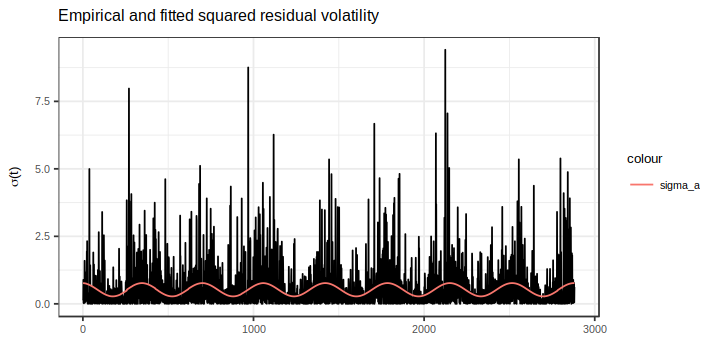

In [45]:
ggplot(dat, aes(x = t)) + 
  geom_line(aes(y = res_sq_log_conc_a)) + theme_bw() +
  geom_line(aes(y = sigma_a, colour = 'sigma_a')) + 
  #geom_line(aes(y = sigma_b, colour = 'sigma_b')) + 
  xlab("") + ylab(TeX("$\\sigma(t)$")) +
  ggtitle("Empirical and fitted squared residual volatility") +
  theme(text = element_text(size=8)) 

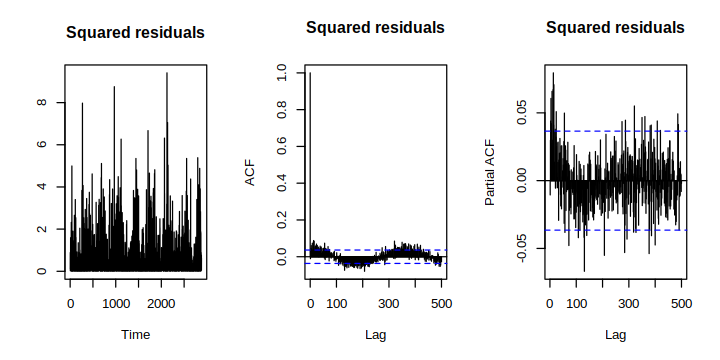

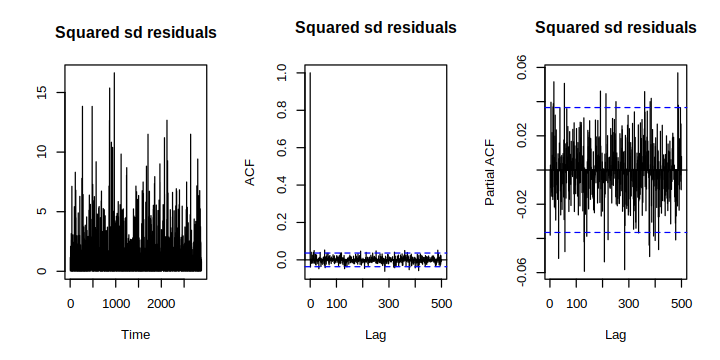

In [46]:
par(mfrow=c(1,3))
plot(dat$res_sq_log_conc_a, main='Squared residuals', ylab='')
acf(dat$res_sq_log_conc_a, lag.max = 500, main='Squared residuals')
pacf(dat$res_sq_log_conc_a, lag.max = 500, main='Squared residuals')

plot(dat$sd_res_log_conc_a**2, main='Squared sd residuals', ylab='')
acf(dat$sd_res_log_conc_a**2, lag.max = 500, main='Squared sd residuals')
pacf(dat$sd_res_log_conc_a**2, lag.max = 500, main='Squared sd residuals')

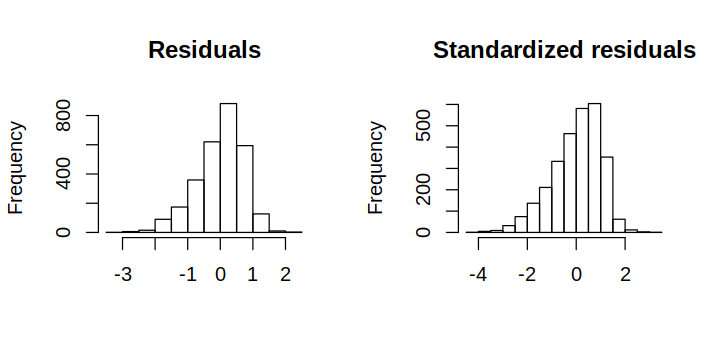

In [47]:
# not normally distributed standardized residuals
par(mfrow=c(1,2))
hist(dat$res_log_conc_a,  main='Residuals', xlab="")
hist(dat$sd_res_log_conc_a,  main='Standardized residuals', xlab="")
#qqnorm(dat$res_log_conc_a)
#qqline(dat$res_log_conc_a, col = "steelblue", lwd = 2)
#qqnorm(dat$sd_res_log_conc_a)
#qqline(dat$sd_res_log_conc_a, col = "steelblue", lwd = 2)

### Fit skewed normal distribution to standardized residuals

In [217]:
sn_par <- snormFit(dat$sd_res_log_conc_a)$par

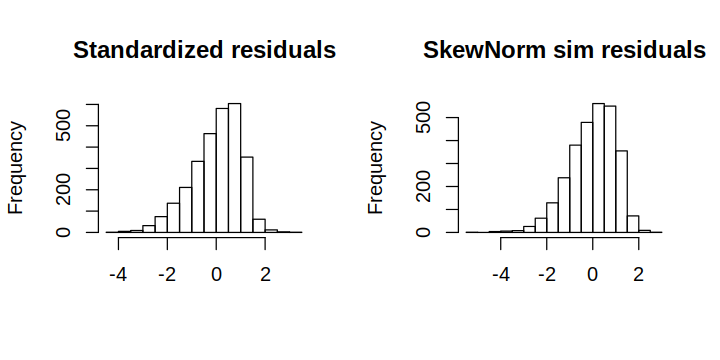

In [226]:
par(mfrow=c(1,2))
hist(dat$sd_res_log_conc_a,  main='Standardized residuals', xlab="")
hist(rsnorm(2881, mean = sn_par[1], sd = sn_par[2], xi = sn_par[3]),main='SkewNorm sim residuals', xlab="")

# Monte carlo simulation of $P(t) = e^{\Lambda(t) + X(t)}$

In [262]:
n <- length(dat$conc)
a <- c(arim$coef[1], arim$coef[2])
sigma_t <- sqrt(dat$sigma_a)

sim_x <- function(n, a, sigma_t, norm){
    res <- norm * sigma_t
    filter(res,filter=a,method='recursive')
}

In [263]:
#ts.plot(sim_x(n, a, sigma_t, norm = rnorm(n = n, mean = 0, sd = 0.8)), ylab="")

In [318]:
# ar(2)
sdat <- dat[, c('day', 'conc')]
nsim <- 2
for (i in 1:nsim){
    # sim with x-residuals from skew normal distribution
    #psim <- as.numeric(exp(dat$log_seas_a + sim_x(n, a, sigma_t, norm = rsnorm(2881, mean = sn_par[1], sd = sn_par[2], xi = sn_par[3]))))
    
    # sim with x-residuals from normal distribution
    #psim <- as.numeric(exp(dat$log_seas_a + sim_x(n, a, sigma_t, norm = rnorm(n = n, mean = 0, sd = 0.6))))
    
    # hacky test with skew normal distribution
    psim <- as.numeric(exp(dat$log_seas_a + sigma_t* rsnorm(2881, mean = sn_par[1], sd = sn_par[2], xi = sn_par[3])))
    
    # hacky test with normal distribution
    #psim <- exp(dat$log_seas_a + sigma_t*rnorm(n = length(dat$log_seas_a), mean = 0.003, sd = 0.75))
    sdat <- cbind(sdat, psim)
}
colnames(sdat) <- c('day', 'conc', paste("ps", 1:nsim, sep = "_"))
#head(sdat)

In [319]:
# ar(1)/ OU
#sdat$psim <- exp(dat$log_seas_a + sim_x(n, a = c(0.6, 0), sigma_t, norm = rnorm(n = n, mean = 0, sd = 0.75)))

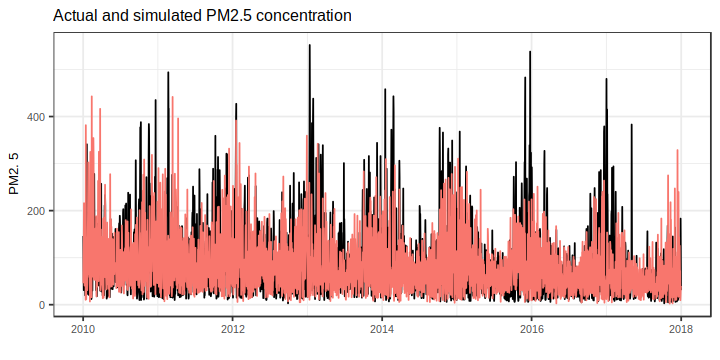

In [321]:
ggplot(sdat, aes(x = day)) + 
  geom_line(aes(y = conc)) + theme_bw() +
  geom_line(aes(y = ps_1, colour = 'ps_1')) + 
  xlab("") + ylab(TeX("PM2.5")) +
  ggtitle("Actual and simulated PM2.5 concentration") +
  theme(text = element_text(size=8), legend.position = "none") 

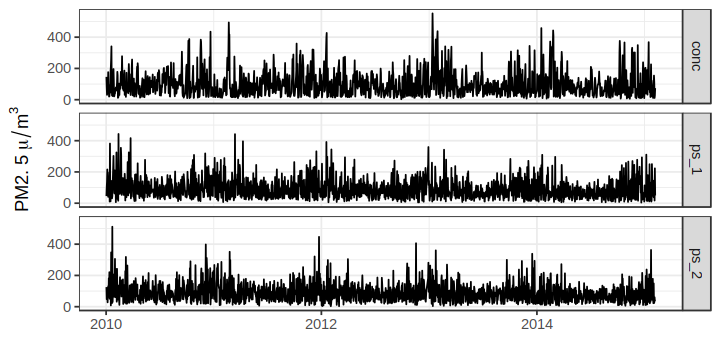

In [332]:
# subset on years
ggplot(melt(head(sdat, 365*5), id.vars = 'day'), aes(x = day, y = value)) + 
       geom_line() + xlab("") + ylab(TeX("PM2.5 $\\mu/m^3$")) +
       theme_bw() + facet_grid(variable ~.) #, scales = "free") 

# Appendix

Links
- https://www.uio.no/studier/emner/matnat/math/MAT4770/v19/timeplan/exam2018.pdf
- https://math.ucalgary.ca/finlab/files/finlab/presentation_201902058851.pdf
- https://kar.kent.ac.uk/32017/1/2013-Computational%20Economics%20-%20pre.pdf